# Recommendation engine (part 2)
This notebook is inspired by the following articles:
- __DEEP BEERS: Playing with Deep Recommendation Engines Using Keras__  
https://medium.com/data-from-the-trenches/deep-beers-playing-with-deep-recommendation-engines-using-keras-part-1-1efc4779568f
- __Recommender Systems in Keras__
https://nipunbatra.github.io/blog/2017/recommend-keras.html
- __Neural Networks for Collaborative Filtering__
https://nipunbatra.github.io/blog/2017/neural-collaborative-filtering.html

In this notebook, we will discover how to implement a recommendation engine with `Keras`.

## Introduction

We will download the MovieLens dataset (http://grouplens.org/datasets/movielens/100k/). We focus only on a subpart of the whole MovieLensdataset (100,000 ratings from 1000 users on 1700 movies).

Documentation about the dataset can be found here: http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

## Loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing

pd.options.display.max_columns = 50

In [2]:
def read_ml20m(nrows=None):
    print("Loading ratings.csv ...")
    ratings = pd.read_csv('ml-20m/ratings.csv', nrows=nrows, dtype={"userId":np.uint32,"movieId":np.uint32,"timestamp":np.uint32})

    print("Loading movies.csv ...")
    movies = pd.read_csv("ml-20m/movies.csv", dtype={"movieId":np.uint32})

    print("Joining datasets ...")
    ratings = ratings.merge(movies, on="movieId", how="inner")

    print("Encoding movieId ...")
    le = preprocessing.LabelEncoder()
    ratings["movieId"] = le.fit_transform(ratings["movieId"])

    ratings["userId"] -= 1
    print("Done!")

    return ratings

In [3]:
ratings = read_ml20m()

Loading ratings.csv ...
Loading movies.csv ...
Joining datasets ...
Encoding movieId ...
Done!


In [4]:
print(ratings.shape)
ratings.head()

(20000263, 6)


,userId,movieId,rating,timestamp,title,genres
0,0,1,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,4,1,3.0,851527569,Jumanji (1995),Adventure|Children|Fantasy
2,12,1,3.0,849082742,Jumanji (1995),Adventure|Children|Fantasy
3,28,1,3.0,835562174,Jumanji (1995),Adventure|Children|Fantasy
4,33,1,3.0,846509384,Jumanji (1995),Adventure|Children|Fantasy


## Data exploration
Let's have a look again at the data. The dataset is much larger than the one used in Part 1 (20 millions ratings) and also the features are slightly different. Let's take advantage of the fact that movie ratings are timestamped and the dataset richer.  
Do you remember the movie Jumanji? What a success, right? :)  
We can have a look at the evolution of the ratings for this movie during time. I began rather high, and as time passes, ratings start to be  lower (the minimum is around 2006 with ratings below 3 which starts to be not so great), before rising again. Maybe some nostalgic viewers watched the movie 10 years after its release and enjoyed it!

In [5]:
jumanji = ratings[ratings.movieId == 1].copy()
jumanji.sort_values("timestamp", inplace=True)
jumanji["timestamp"] = pd.to_datetime(jumanji.timestamp, unit="s")
jumanji.set_index("timestamp", inplace=True)

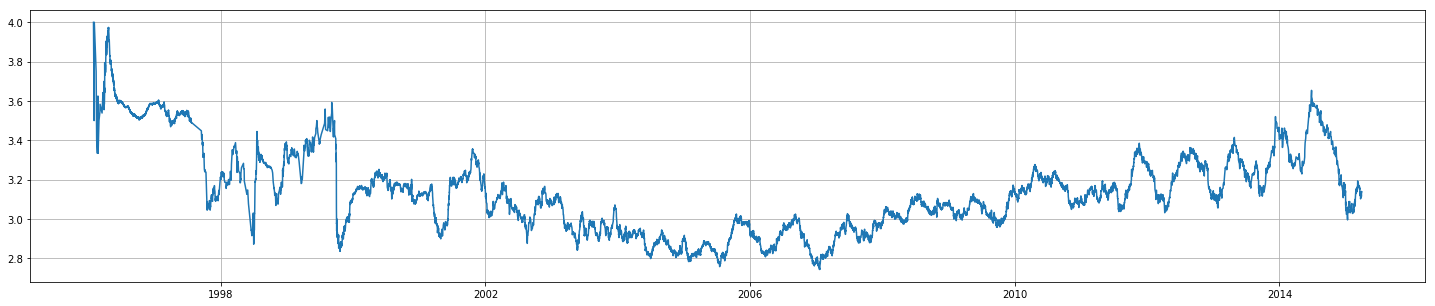

In [6]:
plt.figure(figsize=(25,5))
plt.plot(jumanji.rating.rolling("90D").mean())
plt.grid()
plt.show()

Another movie, or series of movies, which had a great success is Toy Story. Let's see how the ratings evolved for each movie issue.

In [7]:
ts_ind = ratings[ratings.title.str.contains("Toy Story")].groupby("title")["movieId"].apply(lambda x: x.unique()[0])
ts_ind = ts_ind[:3]

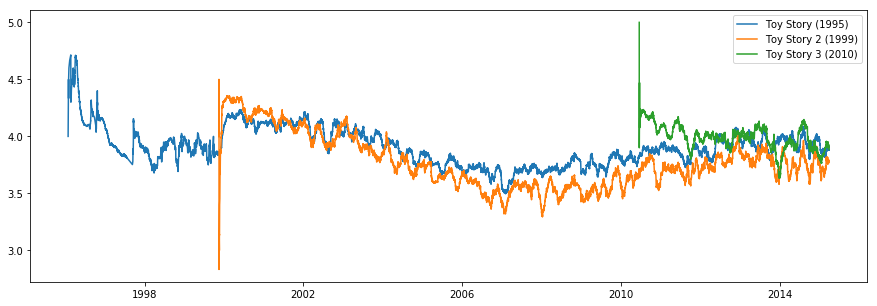

In [8]:
plt.figure(figsize=(15,5))

for title, mid in ts_ind.iteritems():
    ts = ratings[ratings.movieId == mid].copy()
    ts["timestamp"] = pd.to_datetime(ts["timestamp"], unit="s")
    ts.sort_values("timestamp", inplace=True)
    ts.set_index("timestamp", inplace=True)

    plt.plot(ts.rating.rolling("60D").mean(), label=title)

plt.legend()
plt.show()

We see that the movies are quite well rated (actually amongst the best ratings in the dataset). Interstingly, we notice that as new Toy Story went out, the ratings of the previous episode are on the rise when a new one is released. Is it pure coincidence? Maybe the ratings of Toy Story 1 started to go higher when fans knew that a new movie was in preparation? Or maybe Toy Story 2 was released when the interest on Toy Story was at his highest point a few years after its release? I'll leave that to you! :)

## Building an explicit recommendation engine with `keras`

It basically boils down to a regression problem where we try to predict the ratings for each user. This means that a movie will be recommended to a user that (s)he is likely to rate highly.

The first model will be based on a matrix factorisation approach. The idea is to project movie and users in a common latent space.

In [9]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()

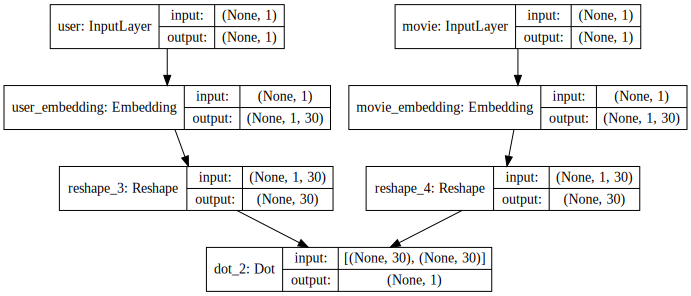

In [11]:
from keras.models import Model
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout, Add
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

userId_input = Input(shape=[1], name='user')
movieId_input = Input(shape=[1], name='movie')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=n_users,
                           input_length=1, name='user_embedding')(userId_input)
user_embedding = Reshape([embedding_size])(user_embedding)

movie_embedding = Embedding(output_dim=embedding_size, input_dim=n_movies,
                           input_length=1, name='movie_embedding')(movieId_input)
movie_embedding = Reshape([embedding_size])(movie_embedding)


# user_bias = Embedding(output_dim=1, input_dim=n_users,
#                       input_length=1, name='user_bias')(userId_input)
# user_bias = Reshape([1])(user_bias)

# movie_bias = Embedding(output_dim=1, input_dim=n_movies,
#                       input_length=1, name='movie_bias')(movieId_input)
# movie_bias = Reshape([1])(movie_bias)


y = Dot(1, normalize=False)([user_embedding, movie_embedding])

# y = Add()([y, user_bias, movie_bias])

mf_model = Model(inputs=[userId_input, movieId_input], outputs=y)

mf_model.compile(loss='mse',
                 optimizer=Adam(lr=0.0005))

from IPython.display import SVG, Image, display
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(mf_model, "mf_model.svg", show_shapes=True)
display(SVG("mf_model.svg"))

In [11]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_test = train_test_split(ratings, test_size=0.2)

In [12]:
EPOCHS = 50

In [13]:
history = mf_model.fit([ratings_train["userId"], ratings_train["movieId"]],
                       ratings_train["rating"],
                       batch_size=10240, epochs=EPOCHS,
                       validation_split=0.1,
                       initial_epoch=0,
                       shuffle=True, 
                       verbose=0, callbacks=[EarlyStopping(patience=5)])

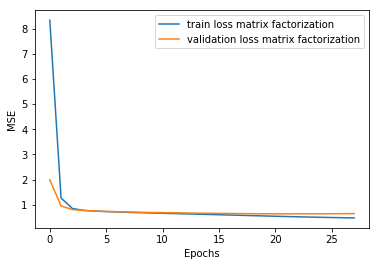

In [14]:
plt.figure()
plt.plot(history.history["loss"], label="train loss matrix factorization")
plt.plot(history.history["val_loss"], label="validation loss matrix factorization")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

Here again, there could be some parameter optimization, especially concerning the number of latent vectors (or embedding size).

### Non-negative Matrix Factorization



In [24]:
def plot_user_movie_embeddings(model):
    user_embedding_learnt = model.get_layer(name='user_embedding').get_weights()[0]
    movie_embedding_learnt = model.get_layer(name='movie_embedding').get_weights()[0]

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    for i in range(user_embedding_learnt.shape[-1]):
        ax1.hist(user_embedding_learnt[:,i],alpha=0.3, 
                 bins=100, 
                 range=(user_embedding_learnt.min(), user_embedding_learnt.max()), 
                 label="user latent factor "+str(i))
        if i >= 10:
            break

    for i in range(movie_embedding_learnt.shape[-1]):
        ax2.hist(movie_embedding_learnt[:,i],alpha=0.3, 
                 bins=100, 
                 range=(movie_embedding_learnt.min(), movie_embedding_learnt.max()), 
                 label="movie latent factor "+str(i))
        if i >= 10:
            break

    ax1.legend()
    ax2.legend()
    ax1.set_title("User Embeddings weights")
    ax2.set_title("Movie Embeddings weights")
    plt.show()

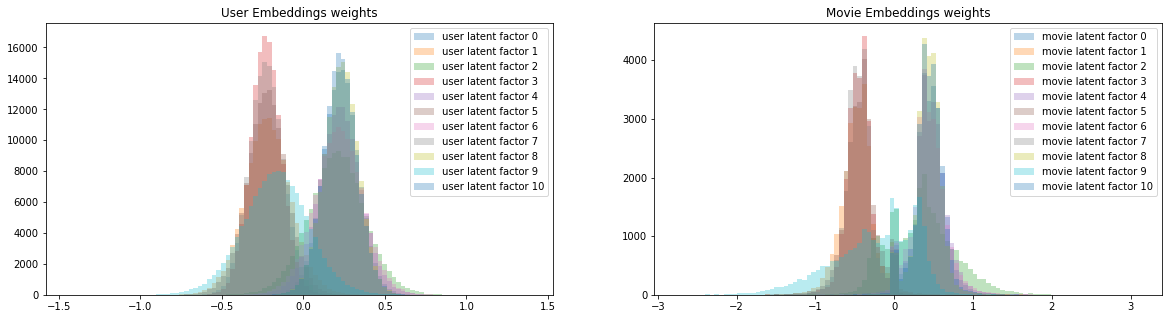

In [25]:
plot_user_movie_embeddings(mf_model)

We can see that both the user embeddings (as well as the movie embeddings) have negative elements. There are some applications which require that the learnt embeddings be non-negative. This approach is also called non-negative matrix factorisation, which we'll workout now.

In [17]:
from keras.constraints import non_neg

userId_input = Input(shape=[1], name='user')
user_embedding = Embedding(output_dim=embedding_size, input_dim=n_users,
                           input_length=1, name='user_embedding', embeddings_constraint=non_neg())(userId_input)
user_vecs = Reshape([embedding_size])(user_embedding)

movieId_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(output_dim=embedding_size, input_dim=n_movies,
                           input_length=1, name='movie_embedding', embeddings_constraint=non_neg())(movieId_input)
movie_vecs = Reshape([embedding_size])(movie_embedding)

y = Dot(1, normalize=False)([user_vecs, movie_vecs])

nnmf_model = Model(inputs=[userId_input, movieId_input], outputs=y)

nnmf_model.compile(loss='mse',
                   optimizer=Adam(lr=0.0005))

history = nnmf_model.fit([ratings_train["userId"], ratings_train["movieId"]],
                         ratings_train["rating"],
                         batch_size=10240, epochs=EPOCHS,
                         validation_split=0.1,
                         shuffle=True, 
                         verbose=0)

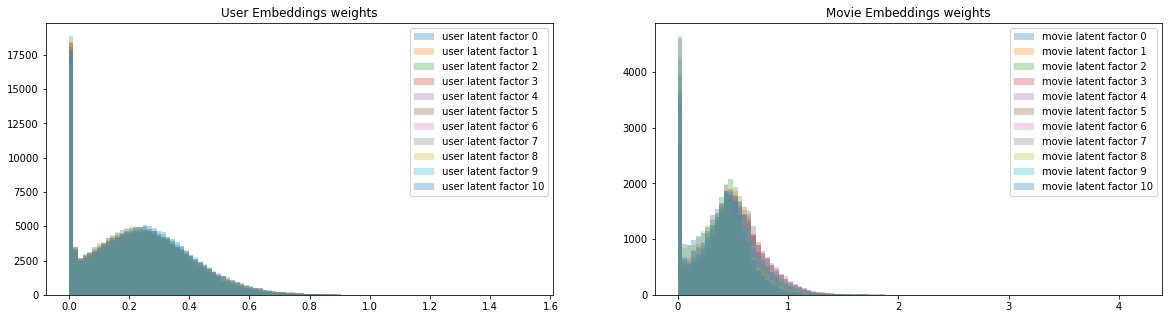

In [26]:
plot_user_movie_embeddings(nnmf_model)

### Neural networks for recommendation
We'll now create a simple neural network for recommendation, or for estimating rating! This model is very similar to the earlier matrix factorisation models, but differs in the following ways:

1. Instead of taking a dot product of the user and the movie embedding, we concatenate them and use them as features for our neural network. Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.
1. Due to #1, we can now have a different dimension of user and movie embeddings. This can be useful if one dimension is larger than the other.


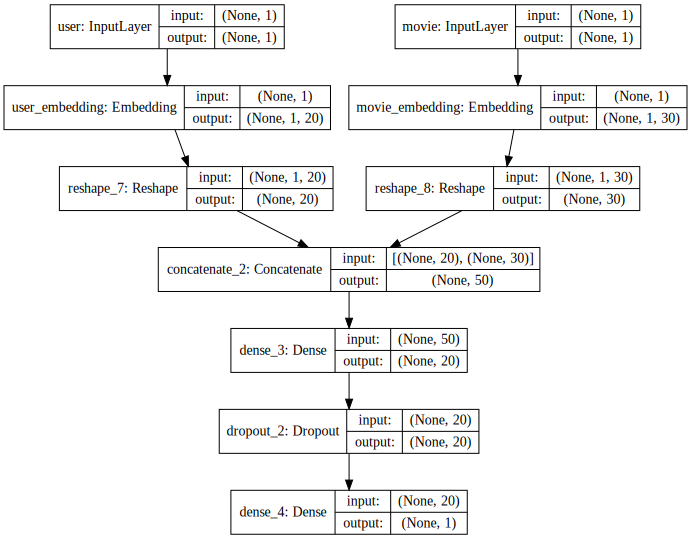

In [13]:
n_latent_factors_user = 20
n_latent_factors_movie = 30

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(output_dim=n_latent_factors_user, input_dim=n_users, input_length=1, name='user_embedding')(user_input)
user_vecs = Reshape([n_latent_factors_user])(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(output_dim=n_latent_factors_movie, input_dim=n_movies, input_length=1, name='movie_embedding')(movie_input)
movie_vecs = Reshape([n_latent_factors_movie])(movie_embedding)

concat = Concatenate()([user_vecs, movie_vecs])
x = Dense(20, activation='relu')(concat)
x = Dropout(0.5)(x)
y = Dense(1)(x)

neuralrec_model = Model(inputs=[user_input, movie_input], outputs=y)

neuralrec_model.compile(loss='mse',
                        optimizer=Adam(lr=0.0005))

# SVG(model_to_dot(neuralrec_model, show_shapes=True).create(prog='dot', format='svg'))
plot_model(neuralrec_model, "neuralrec_model.svg", show_shapes=True)
display(SVG("neuralrec_model.svg"))

In [20]:
history = neuralrec_model.fit([ratings_train["userId"], ratings_train["movieId"]],
                              ratings_train["rating"],
                              batch_size=10240, epochs=EPOCHS,
                              validation_split=0.1,
                              shuffle=True, 
                              verbose=0)

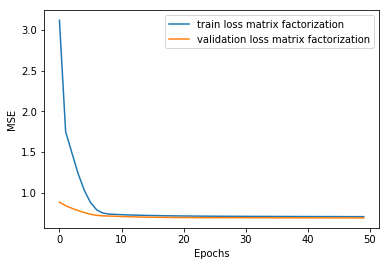

In [21]:
plt.figure()
plt.plot(history.history["loss"], label="train loss matrix factorization")
plt.plot(history.history["val_loss"], label="validation loss matrix factorization")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Conclusion
We explored a few options to make recommandations using the `keras` library, either to emulate a matrix factorization algorithm, or by using more neural-style systems. There is obviously some room for improvement for example by using more information about the movies (release date, genre, ...) but also the timestamp of the reviews. We will try to explore these options (or maybe others!) in a possible Part 3 notebook.